## Семинар 5. Стационарность. Белый шум. MA-процесс.

##### Стационарность

Для начала кратко повторим, что такое стационарность. $y_t$ называется слабо стационарным процессом, если:

$$E[y_t] = \mu$$

$$cov(y_t, y_{t-k}) = \gamma_k$$

Мы уже мельком говорили, что стационарные процессы нам интересны по причине простоты в их прогнозировании. И действительно, чем меньше характеристик процесса изменяется со временем, тем проще построить прогноз. А ещё мы задёшево можем сводить нестационарные ряды к стационарным (ну или почти стационарными). 

На лекции вам уже приводили теорему Вольда и рассказали, что можно разложить слабо стационарный процесс на прогнозируемую часть и MA($\infty$)-процесс. Однако для того, чтобы определить MA-процесс, нужно поговорить о вспомогательном объекте: процессе белого шума (White Noise)

##### Процесс белого шума

Процес белого шума сам по себе является частным случаем стационарного ряда. 

$$E[y_t] = 0$$

$$Var[y_t] = \sigma^2$$

$$cov(y_t, y_{t-k}) = 0 \ \forall \ k \neq 0$$


Попробуем сгенерировать самый простой случай белого шума -- последовательность iid N(0,1) случайных величин.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from scipy.stats import norm, chi2 
from sktime.utils.plotting import plot_correlations


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)


<AxesSubplot: title={'center': 'White Noise process'}, xlabel='Time'>

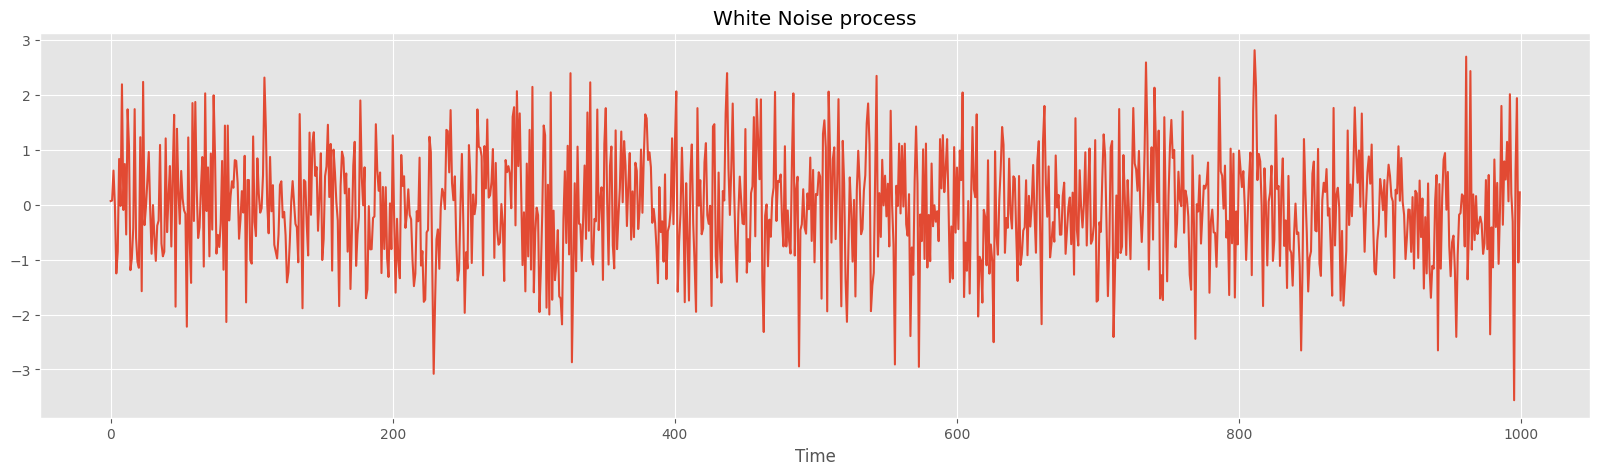

In [18]:
n_obs = 1000
sample = pd.Series(np.random.normal(size=n_obs))

plt.title('White Noise process')
plt.xlabel('Time')
sample.plot()

Попробуем проверить, действительно ли выполняются на таком временном ряде условия белого шума. Начнём с оценки математического ожидания. Построим самую простую оценку -- среднее.

In [19]:
mu_hat = np.mean(sample)
mu_hat

-0.0462863530189988

In [20]:
# p-value гипотезы о равенстве среднего нулю
2 * norm.cdf(mu_hat * np.sqrt(n_obs) / np.std(sample)) 


0.14673373080264304

Проверим дисперсию на разных участках.

In [21]:
# На левом
np.std(sample.head(300))

0.9729152522864262

In [22]:
# На правом
np.std(sample.tail(300))

1.0063888856567704

Проверим автокорреляции. Видим, что значимых автокорреляций не наблюдается. Однако метод "на глазок" нас всё же не устраивает, мы же учёные. Для тестирования процесса на наличие значимых автокорреляций (а значит, по факту, на белошумность) используют Portmanteau тесты. И нет, это не фамилия учёного, это просто название типа теста.

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

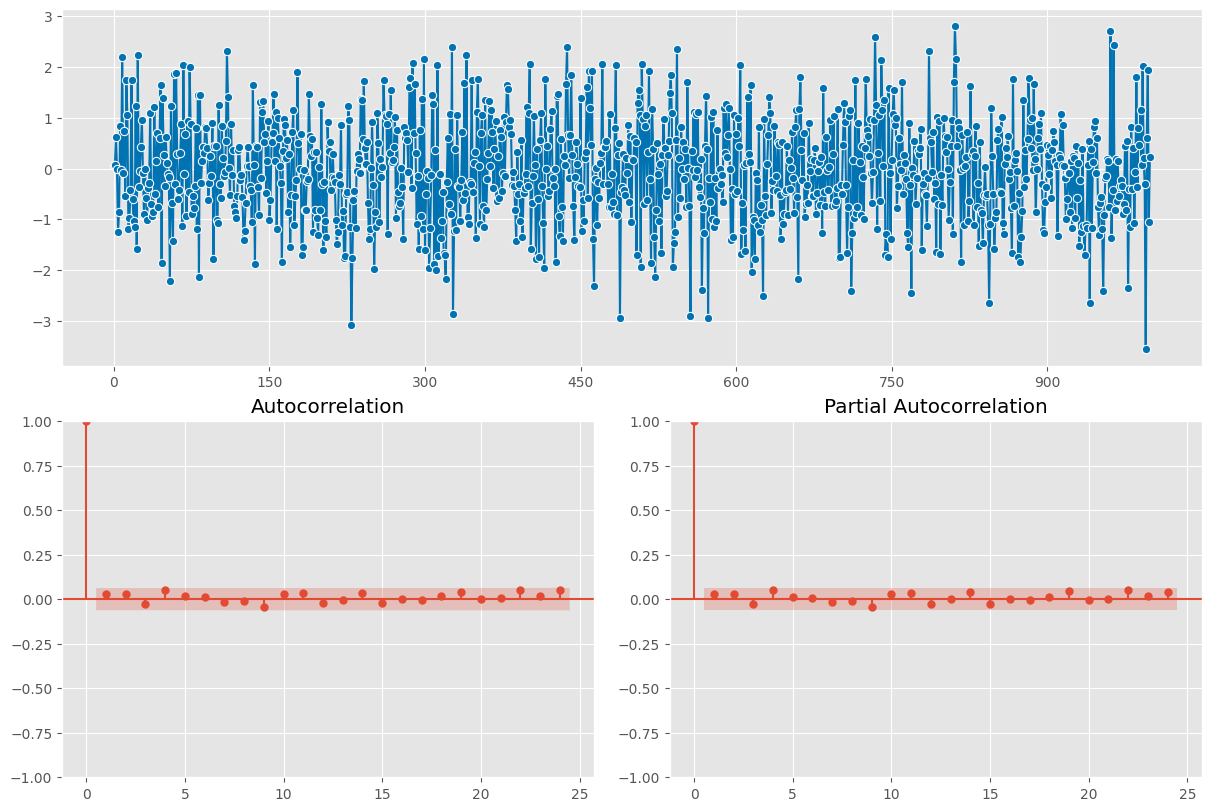

In [23]:
plot_correlations(sample)

С этими тестами в Питоне всё не очень хорошо. Они есть, но они завязаны на использование пакета Statsmodels. Начнём с самого банального теста Box-Pierce:

$$H_0: \hat{\rho}_1 = \cdots = \hat{\rho}_m = 0$$
$$H_A: \exists \hat{\rho}_i \neq 0$$

$$Q(m) = T \sum_{l=1}^m \hat{\rho}_l^2 \sim \chi^2_m$$

Есть и более совершенные тесты. Например, тест Льюнга-Бокса. Хотя на самом деле такой перевод словосочетания Ljung-Box не совсем корректен, ведь Грета Льюнг была женщиной и склонение выбрано заведомо неправильно. Статистика этого теста на малых выборках ближе к хи-квадрат распределению чем статистика Бокса-Пирса

$$Q(m) = T(T+2) \sum_{l=1}^m \frac{\hat{\rho}_l^2}{T-1} \sim \chi^2_m$$

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(sample, lags=20, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.857976,0.354306,0.855407,0.355027
2,1.780747,0.410502,1.774495,0.411788
3,2.419282,0.490055,2.409843,0.491805
4,5.217992,0.265652,5.191795,0.268178
5,5.442584,0.364283,5.414817,0.367377
6,5.586257,0.471093,5.557343,0.474553
7,5.814331,0.561589,5.783368,0.565260
8,5.939528,0.654006,5.907316,0.657613
9,7.893195,0.544944,7.839536,0.550395
10,8.576784,0.572683,8.514938,0.578670


Некоторое время назад мы обсуждали также, что хотелось бы тестировать остатки моделей на наличие автокорреляций. Оказывается, что стандартные тесты не очень для этого подходят. Об этом есть даже некоторый небольшой [тред](https://stats.stackexchange.com/questions/148004/testing-for-autocorrelation-ljung-box-versus-breusch-godfrey), можете почитать, если интересно. Несколько лучше подходит для этих целей тест Бройша-Годфри. Он предполагает, что оценена линейная регрессионная модель и позволяет протестировать остатки такой модели на наличие автокорреляций. Мы попробуем реализовать его в домашке.

In [25]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

##### MA-процесс

Теперь посмотрим повнимательнее на MA-процесс. Как мы уже знаем, для описания стационарного ряда нам необходима модель $MA(\infty)$. Однако, по понятным причинам, оценить её не представляется возможным. Да и не встречается такой острой в этом необходимость. Попробуем поговорить про $MA(k)$-модель. Она выглядит следующим образом:

$$y_t = \mu + \epsilon_t + \alpha_1 \epsilon_{t-1} + \cdots + \alpha_k \epsilon_{t-k}$$

В классических учебниках часто записывается следующая форма:

$$y_t = \mu + \epsilon_t - \alpha_1 \epsilon_{t-1} - \cdots - \alpha_k \epsilon_{t-k}$$

Но понятное дело, что эти формы суть есть одно и то же с точность до знака $\alpha_i$. Мы будем пользоваться первой формулой. В пакетах она более распространена. Попробуем посимулировать и взглянуть на различные MA-процессы.

In [26]:
from statsmodels.api import tsa

Начнём с процесса белого шума, или MA(0):

$$y_t = \mu + \epsilon_t, \ \epsilon_t \sim iid N(0, 1)$$

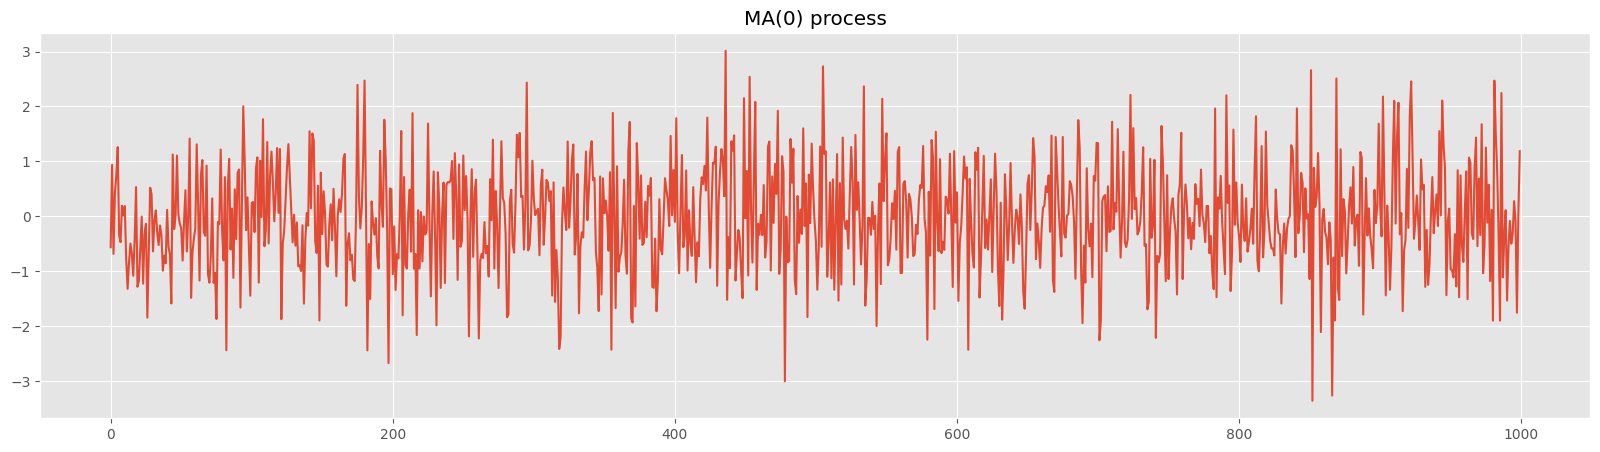

In [27]:
wn_process = tsa.ArmaProcess()
sample = pd.Series(wn_process.generate_sample(nsample=n_obs, burnin = 1000))
sample.plot()
plt.title('MA(0) process');

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

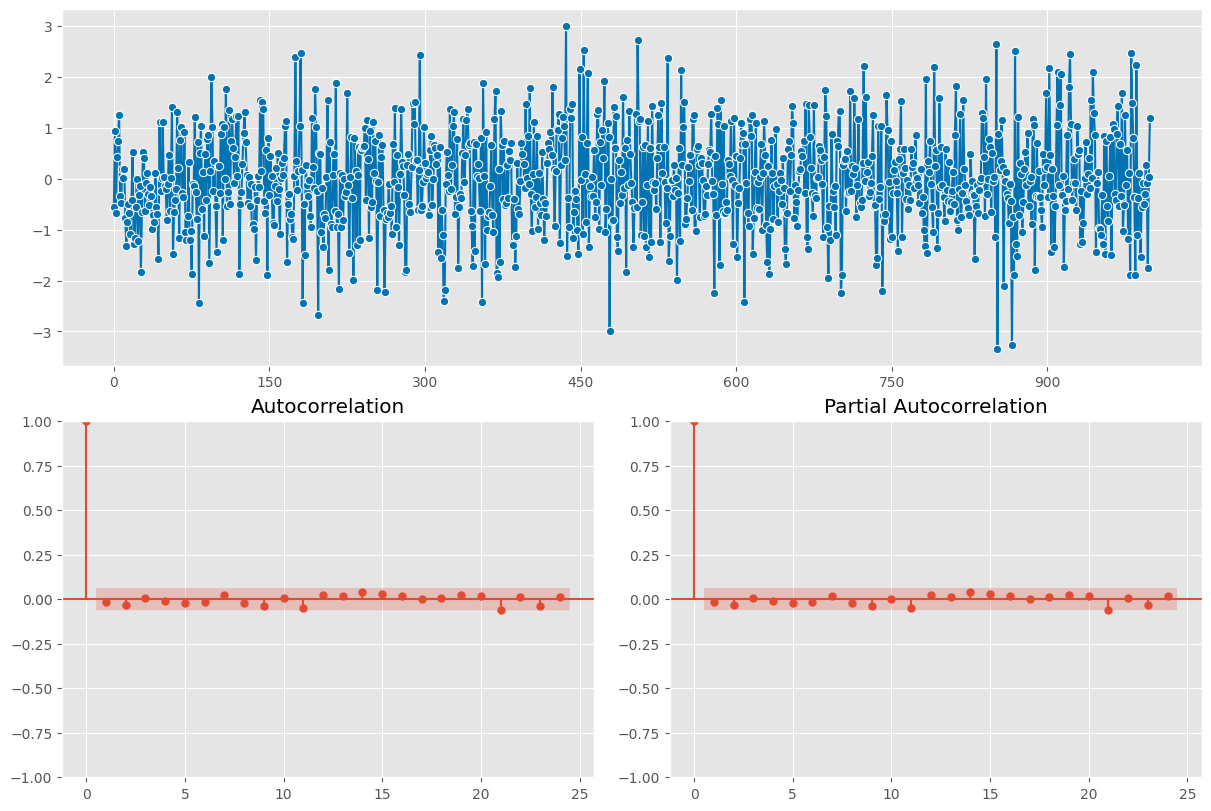

In [28]:
plot_correlations(sample)

Теперь MA(1):

$$y_t = \mu + \epsilon_t + 0.5 \epsilon_{t-1}, \ \epsilon_t \sim iid N(0, 1)$$

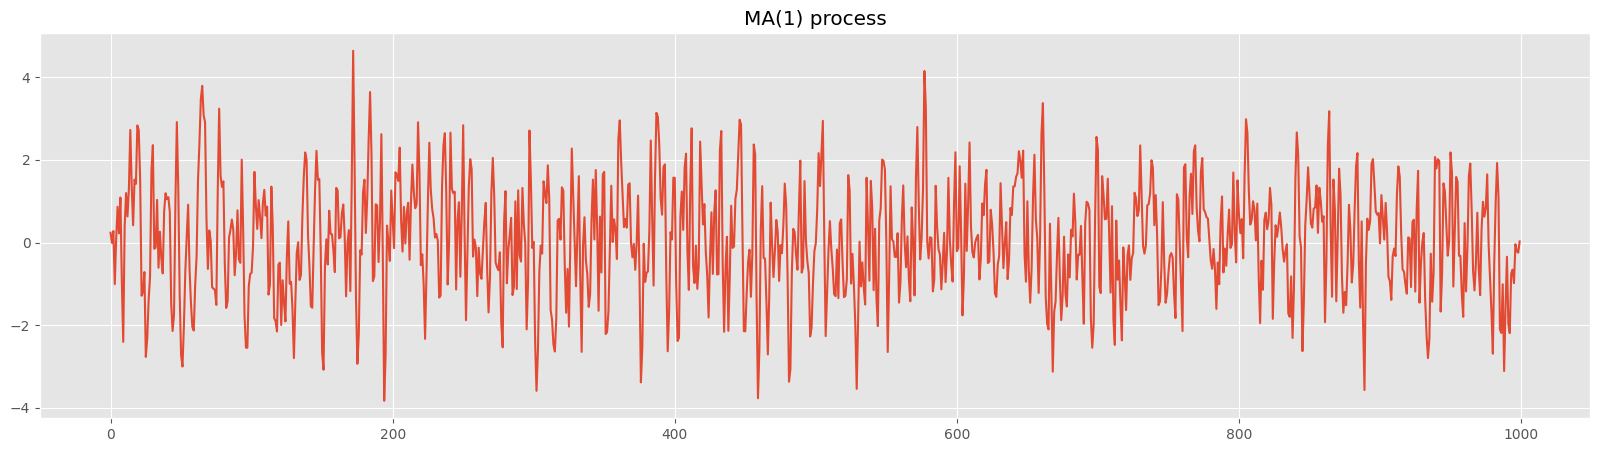

In [29]:
ma_process = tsa.ArmaProcess(ma=[1, 0.9])
sample = pd.Series(ma_process.generate_sample(nsample=n_obs, burnin = 10000))
sample.plot()
plt.title('MA(1) process');

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

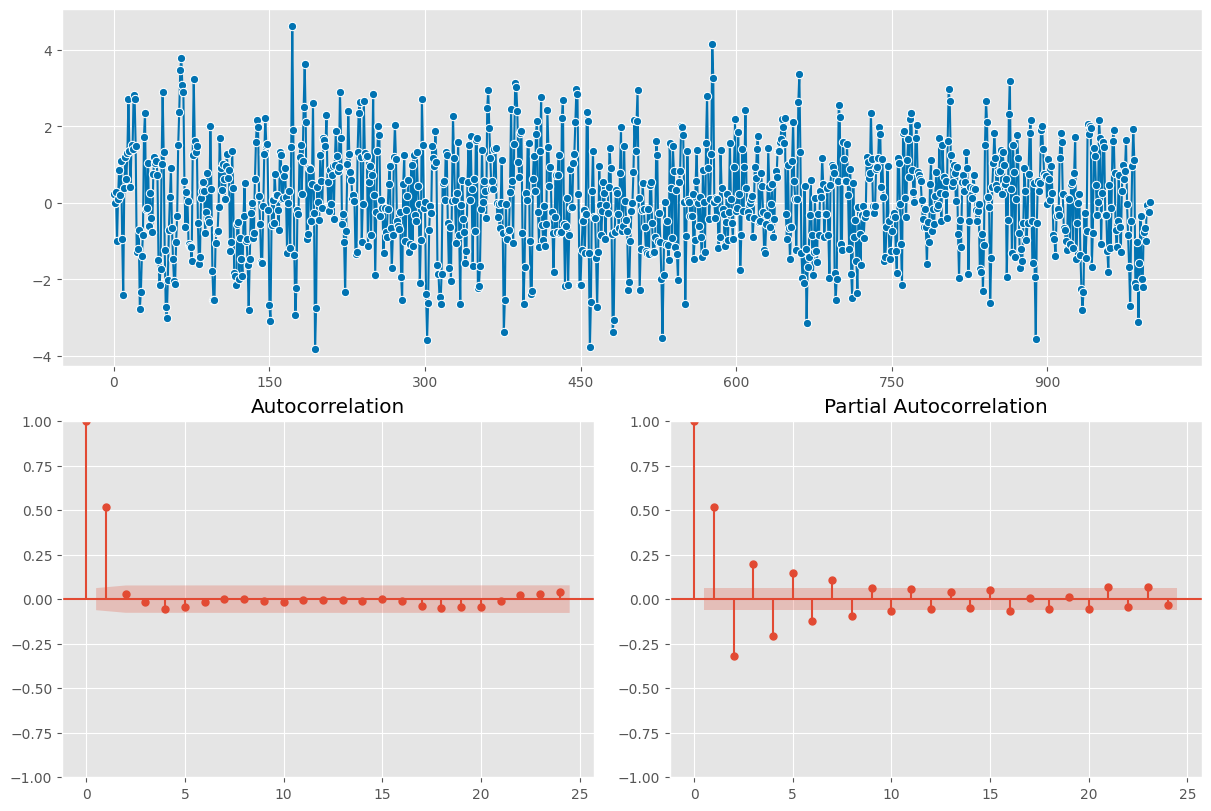

In [30]:
plot_correlations(sample)


MA(5):

$$y_t = \mu + \epsilon_t + 0.9 \epsilon_{t-1} + 0.8 \epsilon_{t-2} + 0.5 \epsilon_{t-3} + 0.6 \epsilon_{t-4} + 0.2 \epsilon_{t-5}, \ \epsilon_t \sim iid N(0, 1)$$

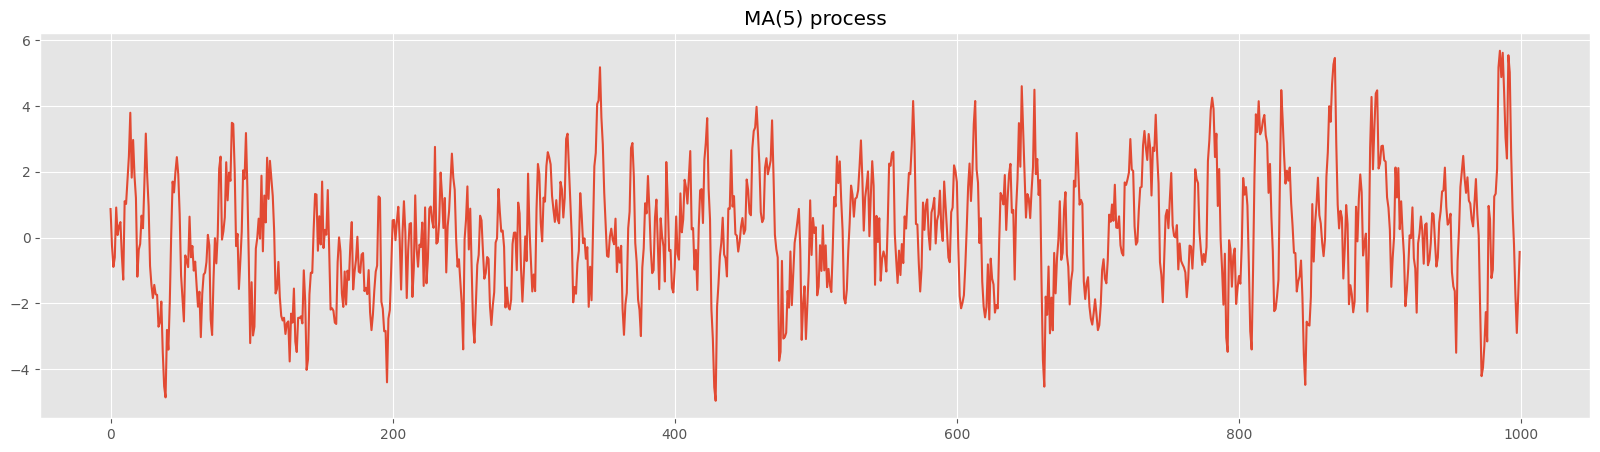

In [31]:
ma_process = tsa.ArmaProcess(ma=[1, 0.9, 0.8, 0.5, 0.6, 0.2])
sample = pd.Series(ma_process.generate_sample(nsample=n_obs, burnin = 1000))
sample.plot()
plt.title('MA(5) process');

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

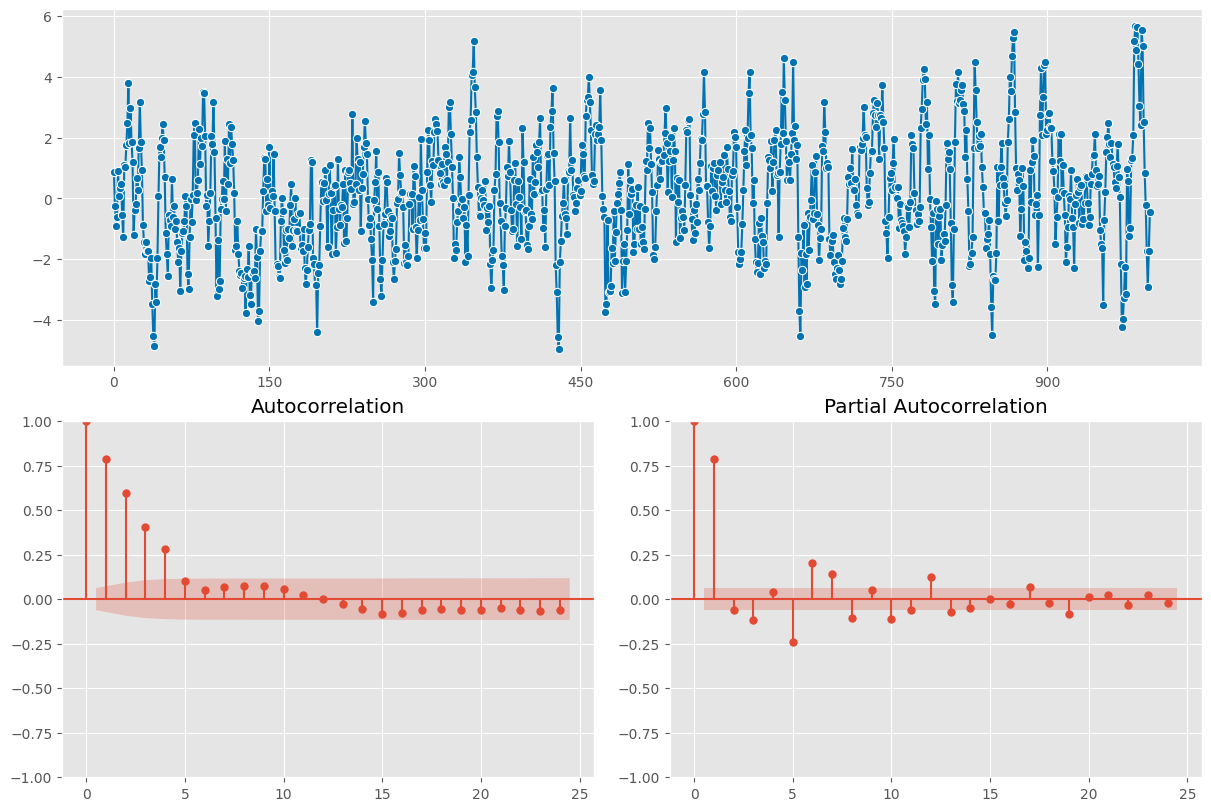

In [32]:
plot_correlations(sample)

Давайте немного поработаем с последним сэмплом. Так как это процесс пятого порядка, у него довольно сложная струткура. Посмотрим, что будет, если оценить модель проще, аналогичную или сложнее чем исходный ряд. Для начала предположим, что мы взяли модель правильного порядка, посмотрев на коррелогаммы. Заодно определим, как вычисляются прогнозы MA(q)-модели.

Выпишем для начала прогноз на один шаг
$$\hat{y}_{T+1} = E[y_{T+1} | T] = E[\mu + \epsilon_{T+1} + \alpha_1 \epsilon_{T} + \ldots + \alpha_k \epsilon_{T-k+1} | T] =$$

$$= \mu + 0 + \alpha_1 \epsilon_{T} + \ldots + \alpha_k \epsilon_{T-k+1}$$

Аналогично на два шага

$$\hat{y}_{T+2} = E[y_{T+2} | T] = E[\mu + \epsilon_{T+2} + \alpha_1 \epsilon_{T+1} + \ldots + \alpha_k \epsilon_{T-k+2} | T] =$$

$$= \mu + 0 + \alpha_1 \cdot 0 + \ldots + \alpha_k \epsilon_{T-k+1}$$

Нетрудно заметить, что после шага k мы сойдёмся к $\mu$

Интервальный прогноз вычисляется аналогично.


In [44]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split

coverage = 0.95
test_size = 50
train, test = temporal_train_test_split(sample, test_size = test_size)

<AxesSubplot: >

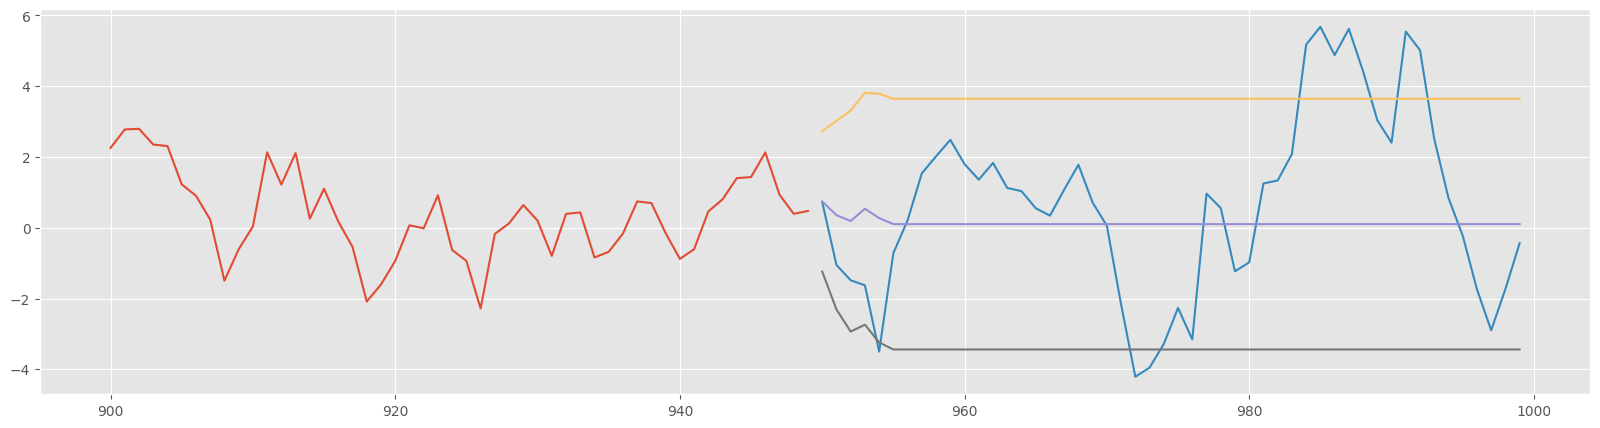

In [45]:
forecaster = ARIMA(order = (0,0,5))

forecaster.fit(train)

forecast = forecaster.predict(list(range(1, test_size+1)))
variance = forecaster.predict_interval(list(range(1, test_size+1)), coverage = coverage)

train.tail(50).plot()
test.plot()
forecast.plot()
variance['Coverage'][coverage]['lower'].plot()
variance['Coverage'][coverage]['upper'].plot()

Посмотрим на остатки одношаговых прогнозов на трейне

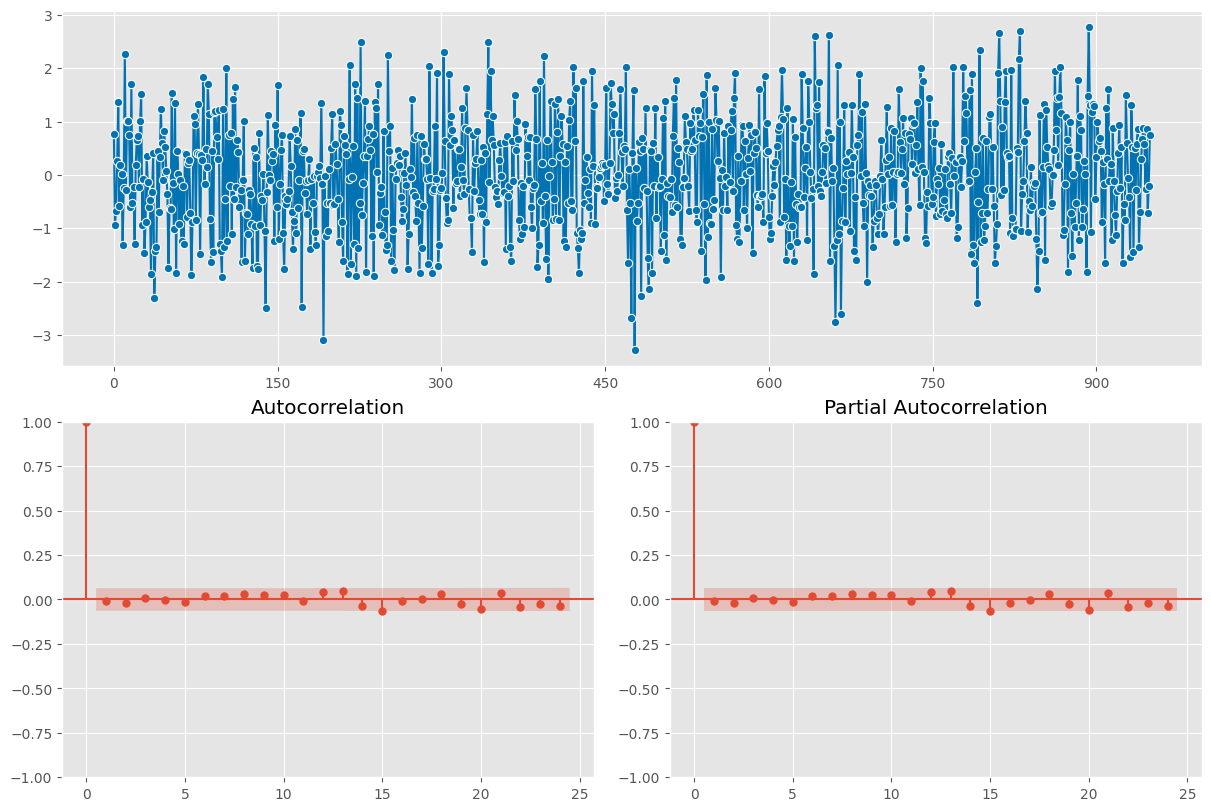

In [46]:
resid = forecaster.predict_residuals()
plot_correlations(resid);

Как видим, значимых автокорреляций нет. Значит, мы построили хорошую линейную модель и аппроксимировали всю линейную динамику. В дополнение проведём тесты.

In [47]:
acorr_ljungbox(resid)

,lb_stat,lb_pvalue
1,0.092009,0.761639
2,0.540230,0.763292
3,0.576628,0.901761
4,0.599416,0.963129
5,0.760737,0.979470
6,1.039629,0.984065
7,1.391125,0.985842
8,2.200053,0.974256
9,2.735161,0.973877
10,3.268424,0.974383


Для некоторого осмысленного количества лагов гипотеза об отсутствии автокорреляций не отвергается. Теперь оценим более слабую модель.

<AxesSubplot: >

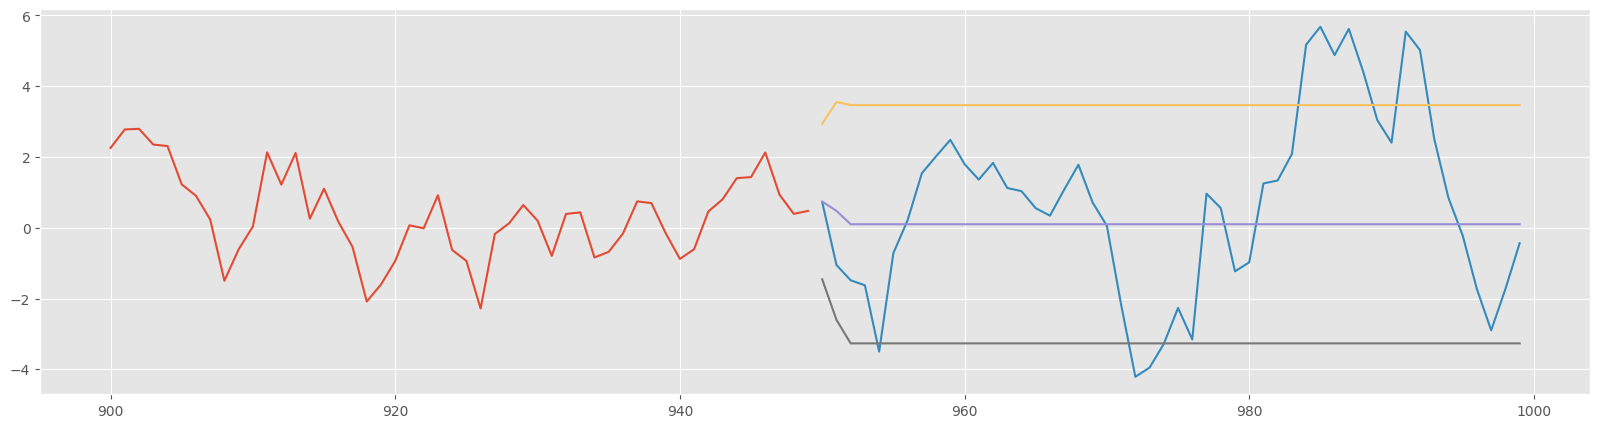

In [49]:
forecaster = ARIMA(order = (0,0,2))

forecaster.fit(train)

forecast = forecaster.predict(list(range(1, test_size+1)))
variance = forecaster.predict_interval(list(range(1, test_size+1)), coverage = coverage)

train.tail(50).plot()
test.plot()
forecast.plot()
variance['Coverage'][coverage]['lower'].plot()
variance['Coverage'][coverage]['upper'].plot()

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

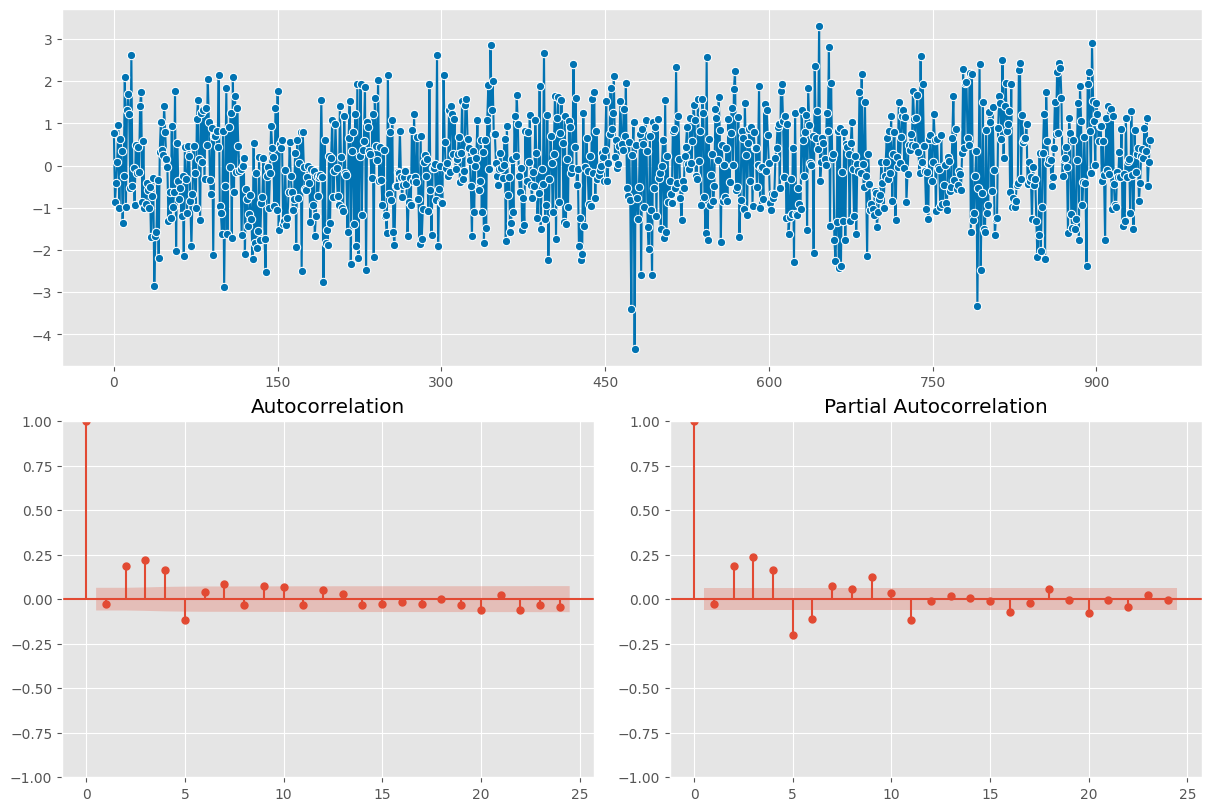

In [50]:
resid = forecaster.predict_residuals()
plot_correlations(resid)

In [51]:
acorr_ljungbox(resid)

,lb_stat,lb_pvalue
1,0.647736,4.209232e-01
2,32.934545,7.052684e-08
3,79.425232,4.076784e-17
4,104.349519,1.165455e-21
5,117.209304,1.223637e-23
6,118.711877,3.037895e-23
7,125.607303,5.193491e-24
8,126.779638,1.314526e-23
9,131.786925,5.087006e-24
10,136.481808,2.213836e-24


Как видим, гипотеза отвергается для любых разумных лагов. Теперь оценим более сложную модель.

<AxesSubplot: >

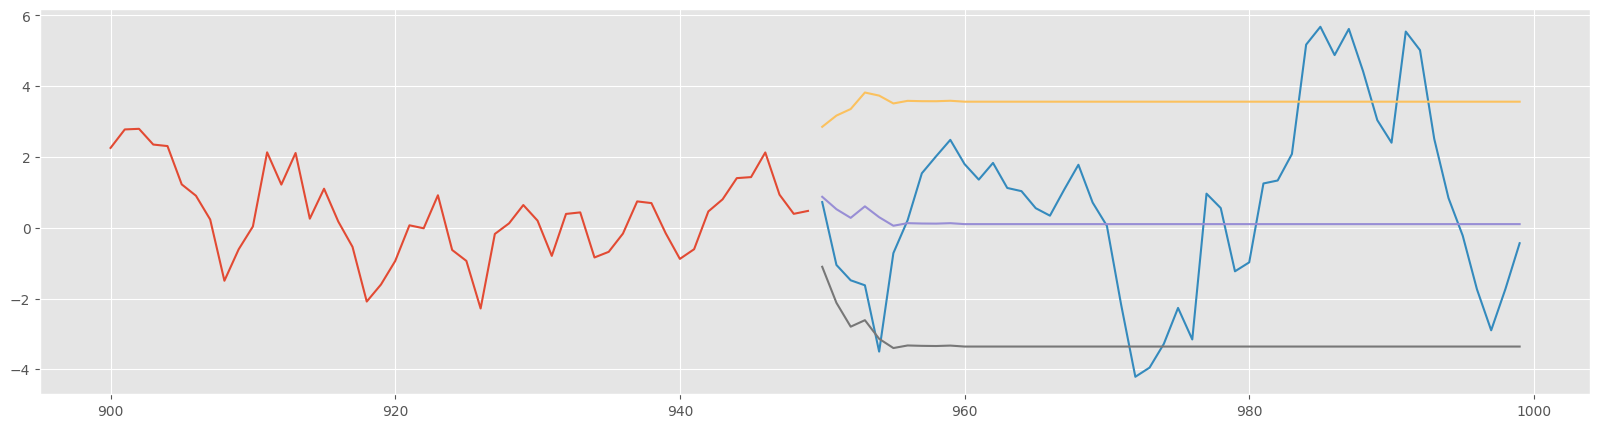

In [53]:
forecaster = ARIMA(order = (0,0,10))

forecaster.fit(train)

forecast = forecaster.predict(list(range(1, test_size+1)))
variance = forecaster.predict_interval(list(range(1, test_size+1)), coverage = coverage)

train.tail(50).plot()
test.plot()
forecast.plot()
variance['Coverage'][coverage]['lower'].plot()
variance['Coverage'][coverage]['upper'].plot()

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

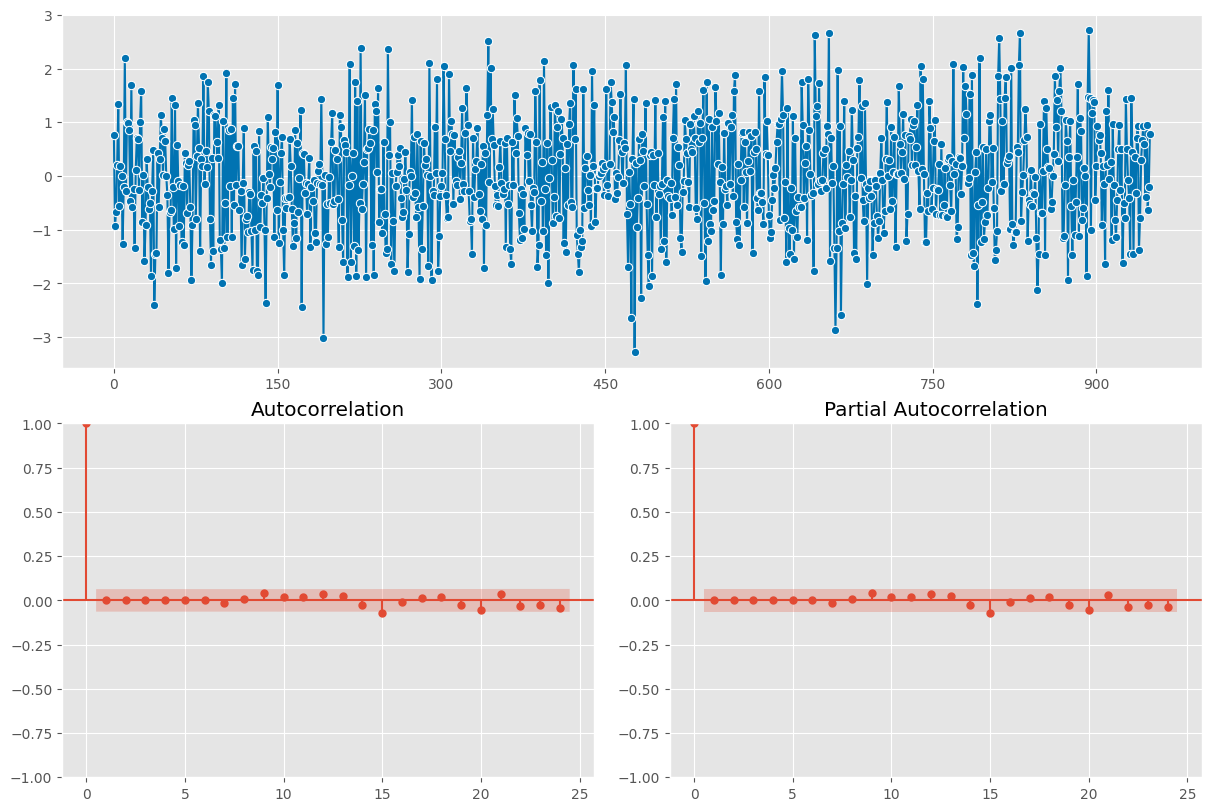

In [54]:
resid = forecaster.predict_residuals()
plot_correlations(resid)

In [57]:
acorr_ljungbox(resid, lags=20)

,lb_stat,lb_pvalue
1,0.000055,0.994075
2,0.000078,0.999961
3,0.004006,0.999933
4,0.014114,0.999975
5,0.017878,0.999998
6,0.017883,1.000000
7,0.155124,0.999989
8,0.218539,0.999995
9,2.087699,0.990004
10,2.340617,0.993000
